In [3]:
import polars as pl
from sklearn.model_selection import train_test_split

f_name = "amazon_cells_labelled.txt"
df = pl.read_csv(f_name, has_header=False, sep="\t", new_columns=["text", "class"])
df = df.with_columns(pl.col("text").str.replace_all("[^\s\w\d]", "").str.to_lowercase())
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2023)

df_train.tail()

text,class
str,i64
"""as i said abov...",0
"""do not buy if ...",0
"""ive also had p...",0
"""small sleek im...",1
"""just does not ...",0


In [4]:
# count the occurrence of each distinct word
def count_words(df):
    return df.select(pl.col("text").str.split(" ").alias("words").flatten()).to_series().value_counts()

VOCAB_SIZE = len(count_words(df)) # number of distinct words in the entire dataset
LABEL_TO_NAME = {0: "Negative", 1: "Positive"}

In [5]:
def build_categories(df_train):
    cats = {}
    for label, df in df_train.partition_by(groups="class", as_dict=True).items():
        wc = count_words(df).get_column("counts").sum()
        table = dict(count_words(df).rows())
        prior = len(df) / len(df_train)
        cats[label] = Category(label, prior, wc, table)
    return cats

class Category:
    label: int
    prior: float
    word_count: int
    table: dict[str, float]
    
    def __init__(self, label, prior, word_count, table):
        self.label = label
        self.prior = prior
        self.word_count = word_count
        self.table = table 

def conditional_prob(word_class_count, word_count):
    return (word_count + 1) / (word_class_count + VOCAB_SIZE)

def sentence_prob(sentence: list[str], class_dict, word_class_count):
    prob = 1.0
    for word in sentence:
        word_count = class_dict.get(word, 0)
        prob *= conditional_prob(word_class_count, word_count)
    return prob

def nb(sentence: list[str], cats):
    best_cat, best = 0, -1
    for cat in cats.values():
        prob = cat.prior * sentence_prob(sentence, cat.table, cat.word_count)
        if prob > best:
            best_cat, best = cat, prob
    return best_cat.label

cats = build_categories(df_train)
LABEL_TO_NAME[nb(["best", "product", "ever"], cats)]

'Positive'

In [6]:
def validation_acc(test_df, cats):
    correct = 0
    for row in test_df.rows():
        words = row[0].strip().split(" ")
        y = row[1]
        y_hat = nb(words, cats)
        if y_hat == y:
            correct += 1
    print(f"{100.0 * correct / len(test_df)}% Accuracy")

validation_acc(df_test, cats)

79.0% Accuracy


In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

lb = preprocessing.MultiLabelBinarizer()
lb.fit([sentence.split(' ') for sentence in df.get_column("text").to_list()])

train_binarized = [sentence.split(' ') for sentence in df_train.get_column("text").to_list()]
test_binarized = [sentence.split(' ') for sentence in df_test.get_column("text").to_list()]
X_train, X_test = lb.transform(train_binarized), lb.transform(test_binarized)
y_train, y_test = df_train.get_column("class").to_list(), df_test.get_column("class").to_list()

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb.score(X_test, y_test)

0.78

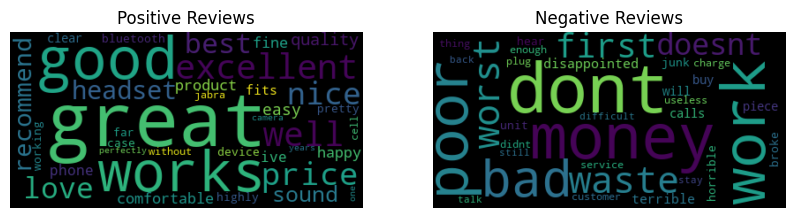

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

cats = build_categories(df)
neg, pos = cats[0], cats[1]

def cloud_prep(cat: dict[str, float], comparison: dict[str, float]):
    parsed = {}
    for key in cat.table:
        freq = cat.table.get(key, 0) - comparison.table.get(key, 0)
        if freq > 5: parsed[key] = freq
    return ''.join([(key+' ')*parsed[key] for key in parsed])

pos_cloud, neg_cloud = cloud_prep(pos, neg), cloud_prep(neg, pos)

fig, axs = plt.subplots(1, 2, figsize=(10, 15))
clouds, titles = [pos_cloud, neg_cloud], ['Positive Reviews', 'Negative Reviews']

for i, (cloud, title) in enumerate(zip(clouds, titles)):
    wordcloud = WordCloud(collocations=False).generate(cloud)
    axs[i].set_title(title)
    axs[i].axis('off')
    axs[i].imshow(wordcloud, interpolation='bilinear')